In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

2022-07-21 11:19:30.378416: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-07-21 11:19:48.221867: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-07-21 11:19:48.409399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 11:19:48.409859: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.6575GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2022-07-21 11:19:48.410007: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-07-21 11:19:48.410185: I tensorflow/stream_execu

In [3]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 512
ARTIFACTS_PATH = 'artifacts/'

BATCH_SIZE = 8 * 1
EPOCHS = 3

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [ ]:
df = pd.read_csv('feature_df.csv')

In [5]:
categories = df['label'].unique()

In [6]:
categories

array([1, 3, 0, 2])

In [7]:
df.columns

Index(['text', 'label', 'word', 'NSen', 'NCha', 'AWLS', 'PWD', 'PDS', 'PSVW',
       'PDSVW'],
      dtype='object')

In [8]:
X_data = df[['text','NSen', 'NCha', 'AWLS', 'PWD', 'PDS', 'PSVW']]
y_data = df[['label']].to_numpy().reshape(-1)

In [9]:
X_data.shape

(1825, 7)

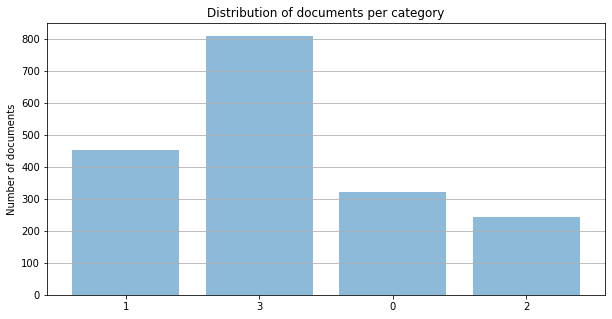

Counter({3: 809, 1: 453, 0: 321, 2: 242})


In [10]:
categories = df[['label']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of documents')
plt.title('Distribution of documents per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [11]:
def calculate_stats(df, split_char=' '):
    categories = df['label'].unique()
    
    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df.iterrows():
        text = row['text']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)
        
        category = row['label']
        
        all_lengths.append(l)
        per_category['lengths'][category].append(l)
    
    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])
    
    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }
    
    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }

In [12]:
def display_lengths_histograms(df_stats, n_cols=3):
    categories = df['label'].unique()
    n_rows = math.ceil(len(categories) / n_cols)
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')
    
    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)
        
        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In [13]:
df_stats = calculate_stats(df)
df_stats['per_category']

,lengths,mean,stdev
1,"[1215, 1247, 2390, 1215, 985, 942, 886, 458, 1...",1158.024283,416.612139
3,"[290, 186, 226, 168, 262, 236, 148, 156, 156, ...",205.765142,78.535539
0,"[5441, 8000, 2889, 21857, 6447, 3242, 5039, 11...",6370.763240,4037.887735
2,"[3953, 2796, 710, 5032, 4928, 3041, 1422, 3077...",3118.086777,1573.604013


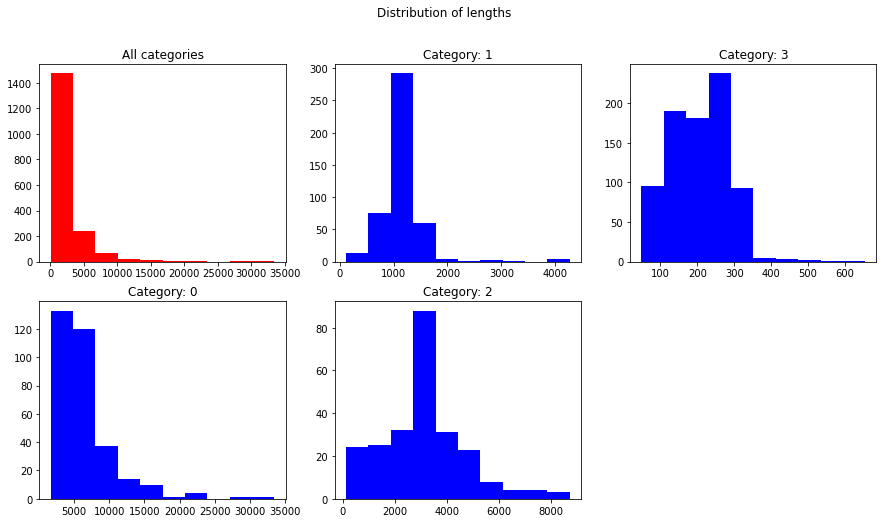

In [14]:
display_lengths_histograms(df_stats)

In [15]:
n_texts = len(X_data)
print('Documents in dataset: %d' % n_texts)

categories = df['label'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

print('Done!')

Documents in dataset: 1825
Number of categories: 4
Done!


In [16]:
def roberta_encode(data, tokenizer):
    texts = data[['text']].to_numpy().reshape(-1)
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification
    k=0
    for kk, row in data.iterrows():
#         print(k)
        text = row[['text']]
        features = list(row[['NSen', 'NCha', 'AWLS', 'PWD', 'PDS', 'PSVW']])
        
        # Tokenize
        tok_text = tokenizer.tokenize(text['text'])
    
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
#         print(len(enc_text))
#         enc_text.extend(features)
#         print(len(enc_text))

        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
#         print(input_length)
#         print("==============")
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1
        k += 1
    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [17]:
# Transform categories into numbers
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c
    
    y_data[index] = category_id

# Display dictionary
category_to_name

{0: 1, 1: 3, 2: 0, 3: 2}

In [54]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=123) # random_state to reproduce results 

In [55]:
X_train = pd.concat([X_train, X_test[:480]])
y_train = np.concatenate((y_train, y_test[:480]))

In [56]:
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [58]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)
# X_val = roberta_encode(X_val, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')
# y_val = np.asarray(y_val, dtype='int32')

In [23]:
from tensorflow.keras.utils import to_categorical

y_train1 = to_categorical(y_train, num_classes=4)
y_test1 = to_categorical(y_test, num_classes=4)

In [24]:
def build_model(n_categories):
#     with strategy.scope():
    input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
    input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
    input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

    # Import RoBERTa model from HuggingFace
    roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
    x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

    # Huggingface transformers have multiple outputs, embeddings are the first one,
    # slice out the first position
    x = x[0]

    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [25]:
# with strategy.scope():
model = build_model(n_categories)
model.summary()

2022-07-21 11:20:40.833725: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [26]:
# with strategy.scope():
print('Training...')
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=4,
                    verbose=1,
                    validation_data=(X_test, y_test))

Training...
Epoch 1/10
440/440 [==============================] - 156s 355ms/step - loss: 1.0886 - accuracy: 0.5139 - val_loss: 0.6423 - val_accuracy: 0.7409
Epoch 2/10
440/440 [==============================] - 154s 350ms/step - loss: 0.4023 - accuracy: 0.8520 - val_loss: 0.1748 - val_accuracy: 0.9398
Epoch 3/10
440/440 [==============================] - 155s 351ms/step - loss: 0.0439 - accuracy: 0.9892 - val_loss: 0.2231 - val_accuracy: 0.9325
Epoch 4/10
440/440 [==============================] - 155s 352ms/step - loss: 0.0081 - accuracy: 0.9977 - val_loss: 0.1481 - val_accuracy: 0.9653
Epoch 5/10
440/440 [==============================] - 155s 352ms/step - loss: 9.5951e-04 - accuracy: 1.0000 - val_loss: 0.1406 - val_accuracy: 0.9672
Epoch 6/10
440/440 [==============================] - 154s 350ms/step - loss: 4.0857e-04 - accuracy: 1.0000 - val_loss: 0.1527 - val_accuracy: 0.9672
Epoch 7/10
440/440 [==============================] - 154s 351ms/step - loss: 2.4664e-04 - accuracy: 1.0

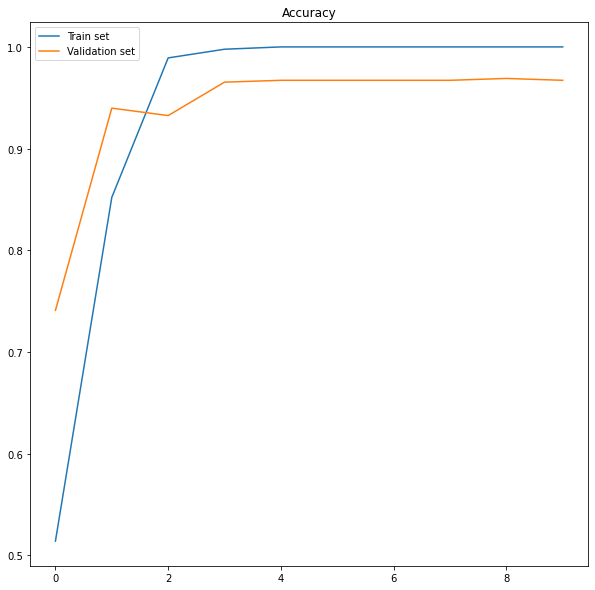

In [27]:

plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

In [28]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]
    print(y_pred)
    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [29]:
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score,precision_score, recall_score, f1_score

In [75]:
def modelEvaluation(predictions, y_test_set, model_name, classes):
    # Print model evaluation to predicted result    
    print("==========",model_name,"==========")
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test_set, predictions)))    
#     print ("\nClassification report : \n", classification_report(y_test_set, predictions, target_names = classes))
#     print ("\nConfusion Matrix : \n", confusion_matrix(y_test_set,predictions))
    sns.heatmap(confusion_matrix(y_test_set, predictions),annot=True,yticklabels=classes, xticklabels=classes, fmt='g',cmap='jet')
   
    plt.tight_layout()
    plt.show()
    results = [accuracy_score(y_test_set, predictions), precision_score(y_test_set, predictions,average='macro'),
              recall_score(y_test_set, predictions,average='macro'),f1_score(y_test_set, predictions,average='macro')]#store results of model
    return results

In [59]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 96.72%


In [32]:
y_pred = model.predict(X_test)
y_pred = [np.argmax(i) for i in model.predict(X_test)]

In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       123
           1       0.97      0.99      0.98       237
           2       0.99      1.00      1.00       102
           3       0.97      0.88      0.93        86

    accuracy                           0.97       548
   macro avg       0.97      0.96      0.96       548
weighted avg       0.97      0.97      0.97       548



========== roberta ==========

Accuracy on validation set: 0.9672


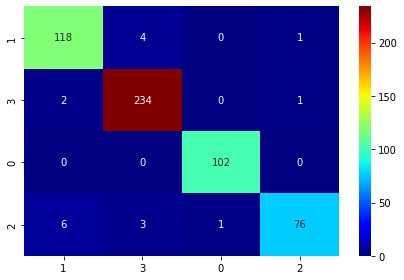

In [76]:
roberta_res=modelEvaluation(y_pred, y_test, 'roberta', categories)